In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import gpitch
import pickle
import copy
import matplotlib.pyplot as plt
from gpitch.covsamp import optimize_kern
from gpitch.covsamp import approximate_kernel as appkern
from gpitch.methods import lfiles_training as fname

In [3]:
# set plot size
plt.rcParams['figure.figsize'] = (16, 4) 

# location data and matrices
path = '/import/c4dm-04/alvarado/datasets/ss_amt/training_data/'
save_path = '/import/c4dm-04/alvarado/results/sampling_covariance/icassp19/'

ninst = 4  # number of intruments
npitch = 3  # number of pitches

# init lists to store data, cov matrixs and samples
init_list = [npitch*[None], npitch*[None], npitch*[None], npitch*[None]]
x = copy.deepcopy(init_list)  
y = copy.deepcopy(init_list)
cov = copy.deepcopy(init_list)
kern = copy.deepcopy(init_list)
xkern = copy.deepcopy(init_list)

if0 = copy.deepcopy(init_list)
freq = copy.deepcopy(init_list)
var = copy.deepcopy(init_list)

p0 = copy.deepcopy(init_list)
pstar = copy.deepcopy(init_list)

kern_init = copy.deepcopy(init_list)
kern_approx = copy.deepcopy(init_list)

S_kern_data = copy.deepcopy(init_list)
S_kern_init = copy.deepcopy(init_list)
S_kern_appr = copy.deepcopy(init_list)
hyperparams = copy.deepcopy(init_list)

rsize = 1600

for i in range(ninst):
    for p in range(npitch):
        print("Learning parametric kernel for " +  fname[i][p].strip('_train.wav'))
        
        # load audio
        x[i][p], y[i][p], fs = gpitch.readaudio(path + fname[i][p])
        
        # get autocorrelation
        kern[i][p] = gpitch.samplecov.autocorr(x=y[i][p], size=rsize)[0]
        
        # get time vector
        xkern[i][p] = x[i][p][0:kern[i][p].size].copy().reshape(-1, 1) # time vector for kernel

        # initialize variance and frequency from data FFT
        if0[i][p] = gpitch.find_ideal_f0([fname[i][p]])[0]
        freq[i][p], var[i][p] = gpitch.init_cparam(y=y[i][p], fs=fs, maxh=15, ideal_f0=if0[i][p], 
                                                   scaled=False)[0:2]

        
        # optimization
        p0[i][p] = np.hstack((np.array([0., 0.1]),  var[i][p], freq[i][p]))  # initialize params
        pstar[i][p] = optimize_kern(x=xkern[i][p], y=kern[i][p], p0=p0[i][p]) 
        print pstar[i][p]

        # get kernel hyperparameters
        npartials = (pstar[i][p].size - 2)/2
        noise_variance = pstar[i][p][0].copy()
        lengthscale =  pstar[i][p][1].copy()
        variance = pstar[i][p][2: npartials + 2].copy()
        frequency = pstar[i][p][npartials + 2:].copy()
        hyperparams[i][p] = [noise_variance, lengthscale, variance, frequency, xkern[i][p], kern[i][p]]
        
        # compute inital and learned kernel
        kern_init[i][p] = appkern(p0[i][p], xkern[i][p])
        kern_approx[i][p] = appkern(pstar[i][p], xkern[i][p])

        # spectral density data, init and learned kernel
        S_kern_data[i][p] = np.abs(sp.fftpack.fft(kern[i][p].reshape(-1,)))[0:512]
        S_kern_init[i][p] = np.abs(sp.fftpack.fft(kern_init[i][p].reshape(-1,)))[0:512]
        S_kern_appr[i][p] = np.abs(sp.fftpack.fft(kern_approx[i][p].reshape(-1,)))[0:512]
        
        #print hyperparams[i][p][1]

        
        # save hyperparameters
        pickle.dump(hyperparams[i][p], open(save_path + fname[i][p].strip('train.wav') + "hyperparams.p", "wb")) 

Learning parametric kernel for 011PFNOM_M60
[  0.00000000e+00   2.27581746e-01   8.57912329e-01   3.41386753e-02
   4.86688060e-03   1.64476646e-02   3.14740375e-02   2.37943266e-03
   4.26985665e-03   3.19071730e-03   3.78268952e-04   4.11306112e-04
   1.07388857e-03   1.49503925e-03   1.07039082e-04   1.70289581e-04
   3.86710357e-04   2.46300229e+02   4.94060343e+02   7.40913598e+02
   9.88908572e+02   1.23787251e+03   1.48799896e+03   1.73973903e+03
   1.99321935e+03   2.24715051e+03   2.50417474e+03   2.76327807e+03
   3.02416524e+03   3.28820771e+03   3.55821920e+03   4.10077519e+03]
Learning parametric kernel for 011PFNOM_M64
[  0.00000000e+00   2.26049892e-01   8.09717055e-05   4.54112320e-01
   4.25965128e-01   4.82463787e-02   4.06900933e-03   5.84198522e-03
   6.26377889e-03   2.18289710e-04   4.72614135e-03   7.18340064e-05
   4.69970575e-03   4.66500831e-04   2.03249698e-04   5.82450575e-05
   6.61789779e-05   3.14998617e+01   3.10875167e+02   6.22122148e+02
   9.34079322e

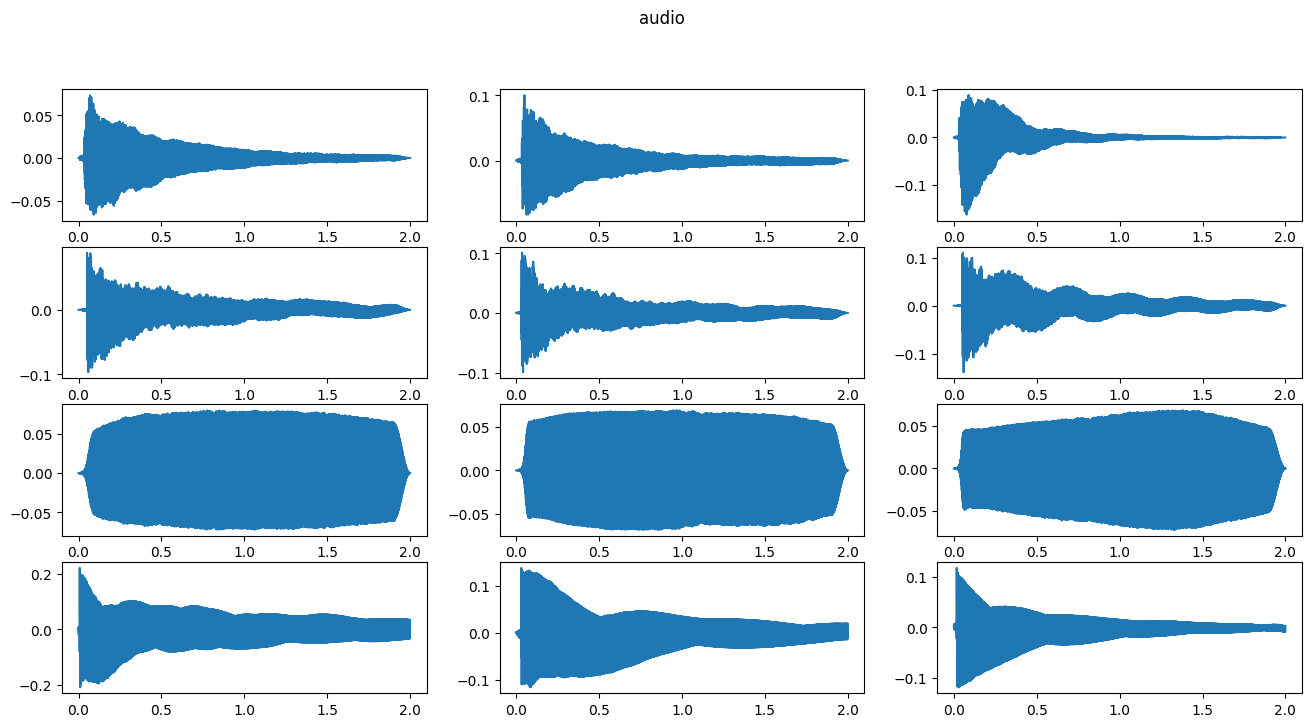

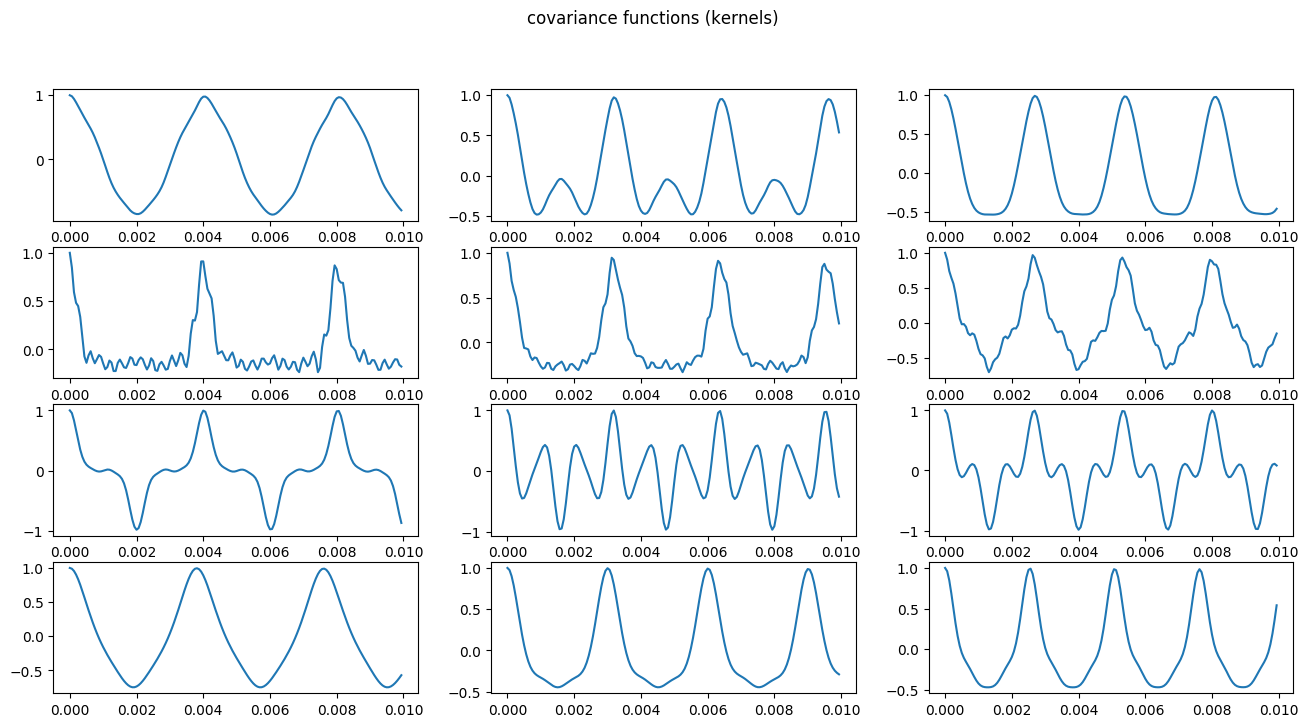

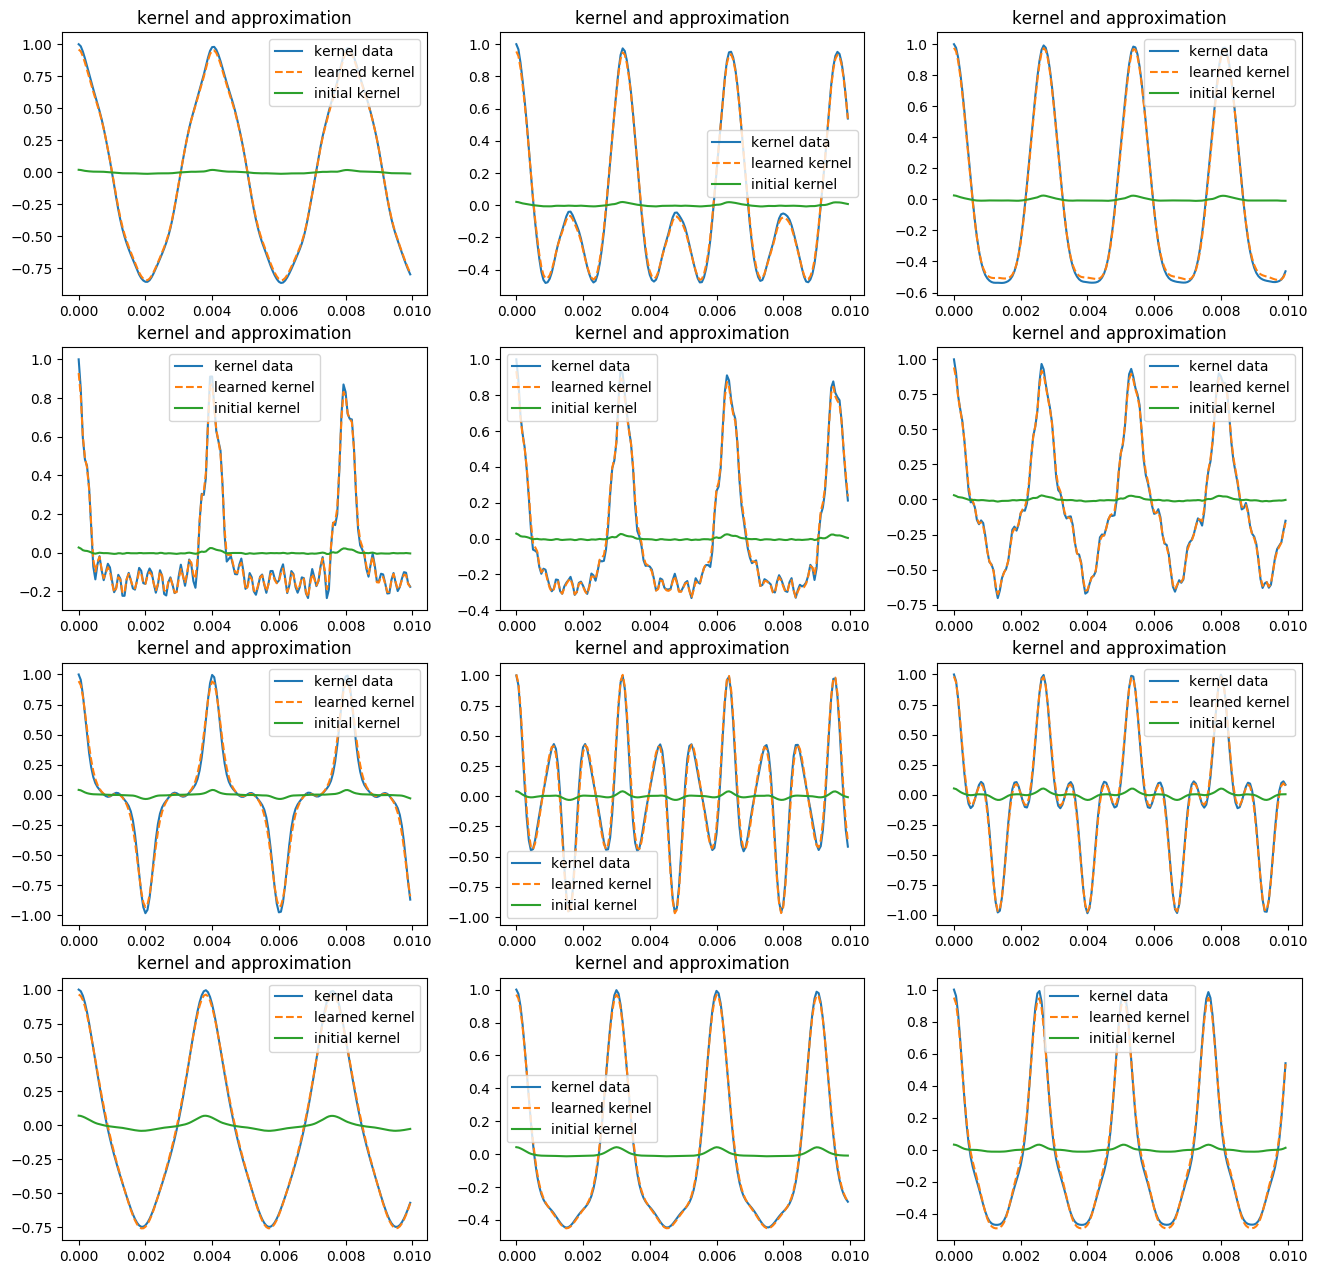

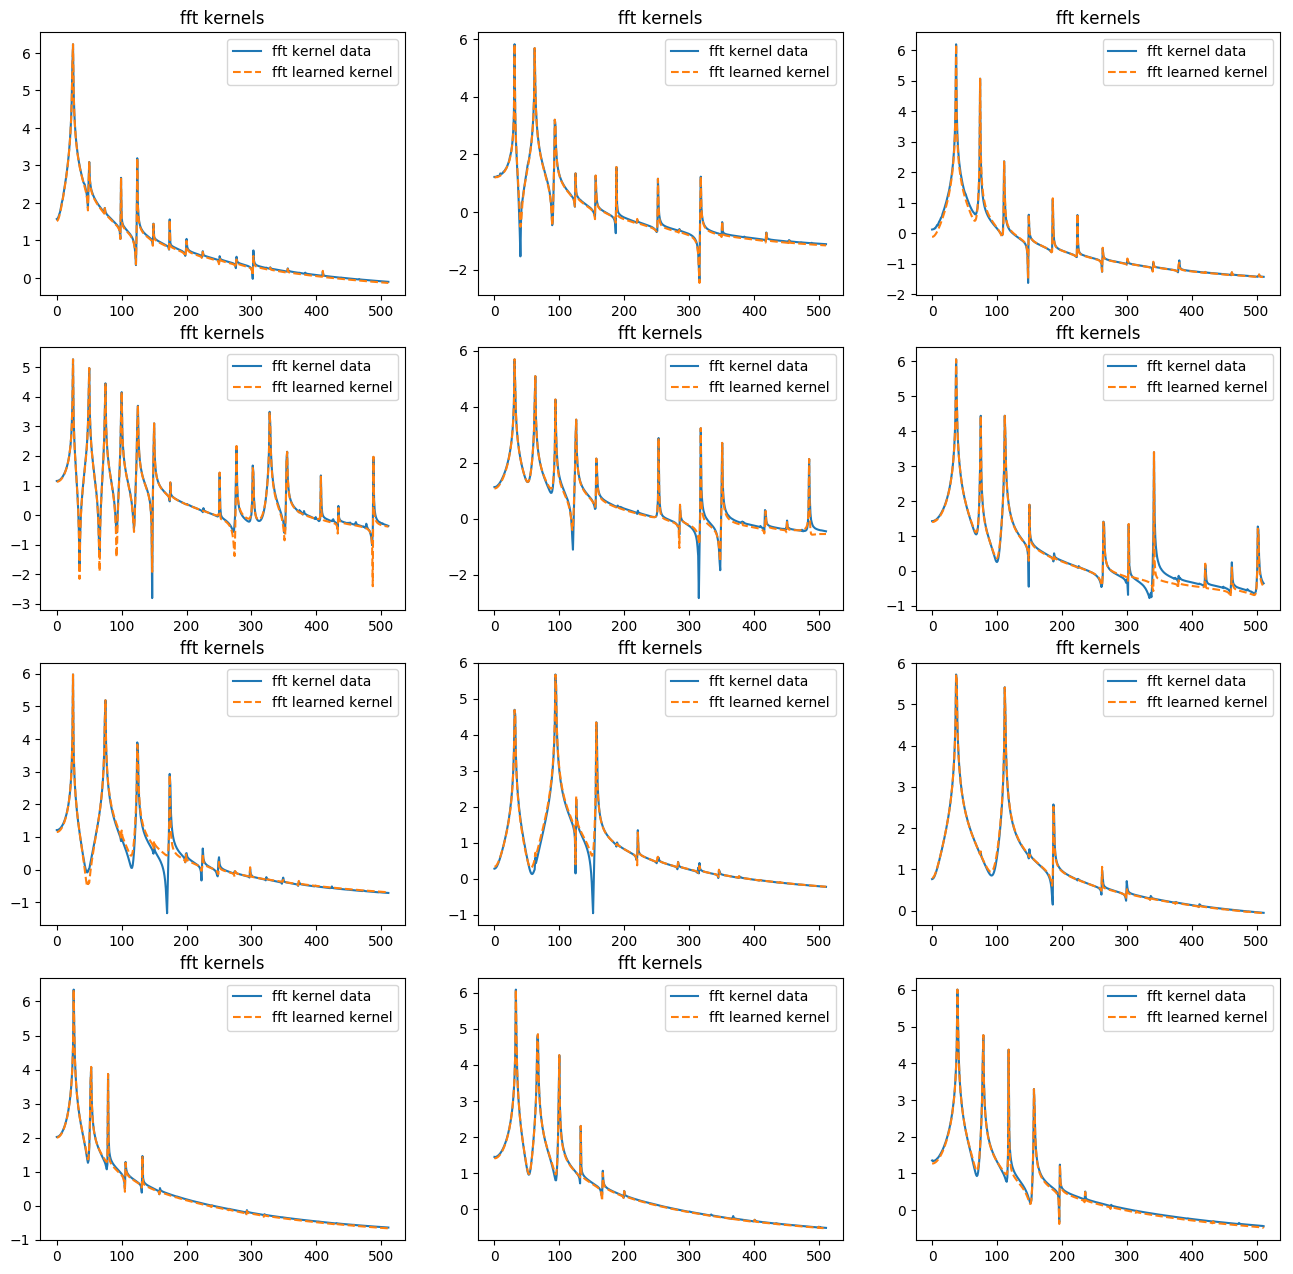

In [4]:
nview = 160
for i in range(ninst):
    for p in range(npitch):
        # visualization
        plt.figure(1, figsize=(16, 8)), plt.suptitle('audio')
        plt.subplot(4, 3, (i*npitch + 1) + p)
        plt.plot(x[i][p], y[i][p])
                
        plt.figure(2, figsize=(16, 8)), plt.suptitle('covariance functions (kernels)')
        plt.subplot(4, 3, (i*npitch + 1) + p)
        plt.plot(xkern[i][p][0:nview], kern[i][p][0:nview]);
        
        
        plt.figure(4, figsize=(16, 16)), plt.title("kernel and approximation")
        plt.subplot(4, 3, (i*npitch + 1) + p)
        plt.plot(xkern[i][p][0:nview], kern[i][p][0:nview] )
        plt.plot(xkern[i][p][0:nview], kern_approx[i][p][0:nview], '--')
        plt.plot(xkern[i][p][0:nview], kern_init[i][p][0:nview])
        plt.legend(['kernel data','learned kernel', 'initial kernel'])
        
        plt.figure(5, figsize=(16, 16)), plt.title("fft kernels")
        plt.subplot(4, 3, (i*npitch + 1) + p)
        plt.plot(np.log(S_kern_data[i][p]))
        plt.plot(np.log(S_kern_appr[i][p]), '--')
        plt.legend(['fft kernel data', 'fft learned kernel'])
        #plt.plot(np.log(S_kern_init[i][p]))
        #plt.legend(['fft kernel data', 'fft learned kernel', 'fft initial kernel'])

In [5]:
n = S_kern_data[2][0].size
F = np.linspace(0., fs/2., n).reshape(-1, 1)

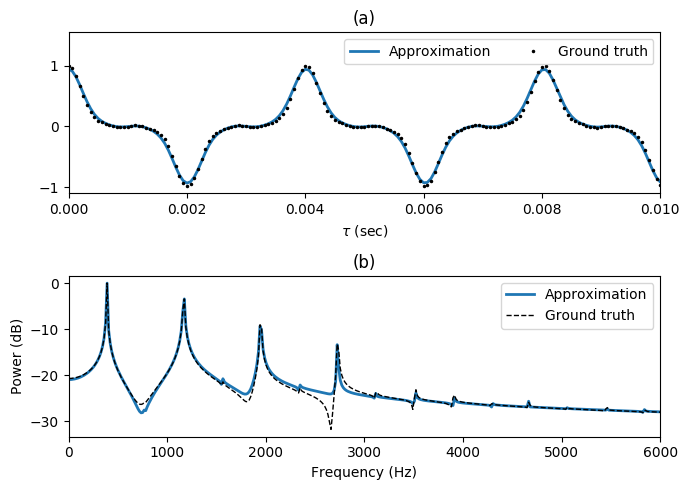

In [6]:
plt.figure(figsize=(7, 5))
plt.subplot(2, 1, 1)
plt.plot(xkern[2][0], kern_approx[2][0], "", lw=2);
plt.plot(xkern[2][0], kern[2][0], ".k", lw=1, ms=3);
plt.xlim(0., 0.01)
plt.ylim(-1.1, 1.55)
plt.xlabel(r'$\tau$ (sec)')
plt.title("(a)")
plt.legend(["Approximation", "Ground truth"], ncol=2, frameon=1)

plt.subplot(2, 1, 2)
plt.plot(F, 10*np.log10(S_kern_appr[2][0]/np.max(S_kern_appr[2][0])), "", lw=2)
plt.plot(F, 10*np.log10(S_kern_data[2][0]/np.max(S_kern_data[2][0])), "k--", lw=1)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.title("(b)")
plt.legend(["Approximation", "Ground truth"], ncol=1, frameon=1)
plt.xlim(0, 6000)


plt.tight_layout()
plt.savefig("kernel_15.pdf")


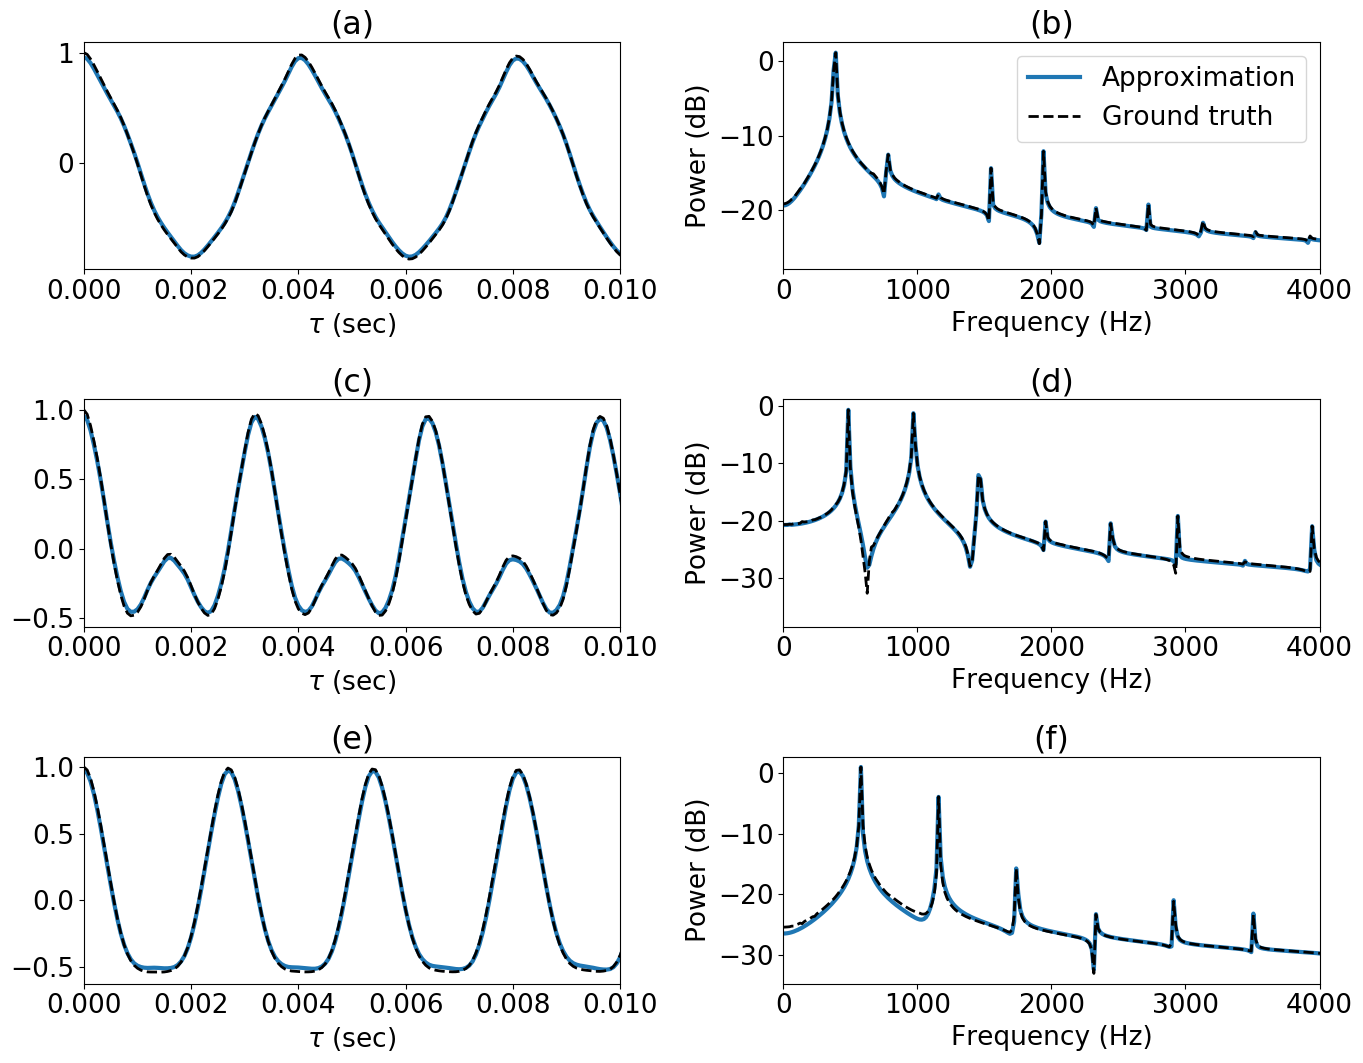

In [37]:
plt.rcParams.update({'font.size': 19})
plt.figure(figsize=(14, 11))

title = ["(a)", "(c)", "(e)", "(b)", "(d)", "(f)"]
for i in range(3):
    ax1 = plt.subplot(3, 2, 2*i+1)
    plt.plot(xkern[2][0], kern_approx[0][i], "C0", lw=3);
    plt.plot(xkern[2][0], 0.0 + kern[0][i], "k--", lw=2);
    plt.xlim(0., 0.01)
    #plt.ylim(-1., 1.675)
    plt.xlabel(r'$\tau$ (sec)')
    plt.title(title[i])
    #plt.legend(["Approximation", "Ground truth"], ncol=2, frameon=1)
    
    plt.subplot(3, 2, 2*i+2)
    plt.plot(F, 10*np.log10(S_kern_appr[0][i]/np.max(S_kern_appr[2][0])), "C0", lw=3)
    plt.plot(F, 10*np.log10(S_kern_data[0][i]/np.max(S_kern_data[2][0])), "k--", lw=2)

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (dB)")
    plt.title(title[i + 3])
    if i ==0:
        plt.legend(["Approximation", "Ground truth"], ncol=1, frameon=1)
    plt.xlim(0, 4000)

plt.tight_layout()

plt.savefig("3_kernels.pdf")